In [1]:
from functions import *
# multiprocessing.set_start_method('spawn') 

In [2]:
def visualize_dmap(dmap, vmax=None, save_path=''):
    """Plot a distance map 
    
    Parameters
    ----------
    
    """
    # Create a new matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # Plot using imshow
    if vmax is None: 
        heatmap = ax.imshow(dmap, cmap='hot', aspect='auto', vmin=0)
    else:
        heatmap = ax.imshow(dmap, cmap='hot', aspect='auto', vmin=0, vmax=vmax)
        
    cb = fig.colorbar(heatmap, ax=ax)
    cb.set_label('Euclidean distance [a.u.]')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

In [2]:
polymer_directory_list = {'SARW': r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/SelfAvoidingRandomWalk/"} \
    | {'LE{}'.format(i): r"/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_{}/".format(i) for i in range(4)}

In [4]:
polymer_directory_list

{'SARW': '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/SelfAvoidingRandomWalk/',
 'LE0': '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_0/',
 'LE1': '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_1/',
 'LE2': '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_2/',
 'LE3': '/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_3/'}

In [3]:
def load_polymer_hdf5(polymer_directory):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_monomers = 100
    num_polymers = len(URIs)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in enumerate(URIs):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:100, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:100, :]))
    return polys, dmaps

In [4]:
polys_dict = {}
dmaps_dict = {}
for key, val in polymer_directory_list.items():
    polys, dmaps = load_polymer_hdf5(val)
    polys_dict[key] = polys
    dmaps_dict[key] = dmaps

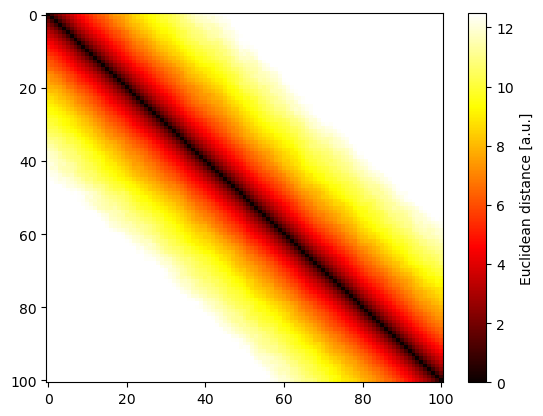

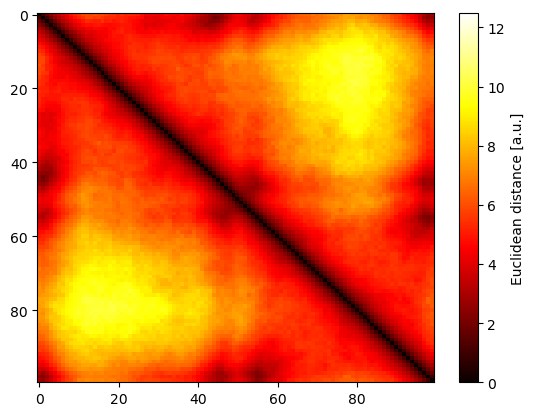

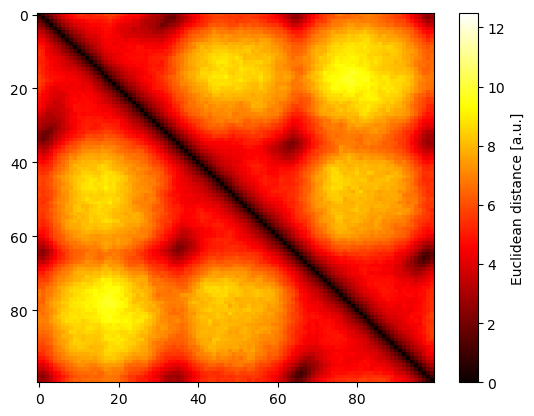

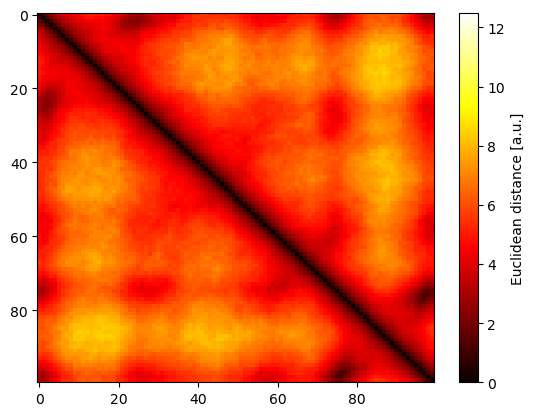

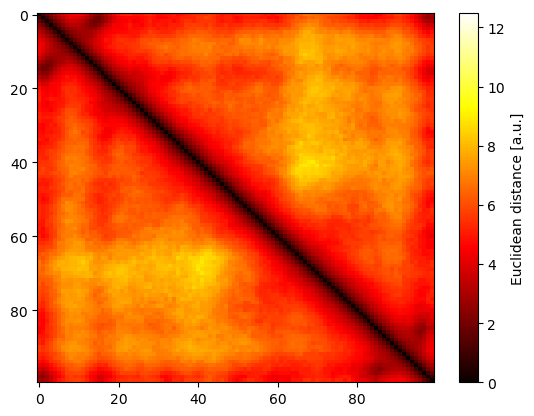

In [7]:
for _, dmaps in dmaps_dict.items():
    dmap_median = np.median(dmaps, axis=2)
    heatmap1 = plt.imshow(dmap_median, cmap='hot', aspect='auto', vmin=0, vmax=12.5)
    cb1 = plt.colorbar(heatmap1)
    cb1.set_label('Euclidean distance [a.u.]')
    plt.show()

In [5]:
# Define save path
save_directory = r'/mnt/home/tudomlumleart/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240530/'

In [ ]:
# Visualize some example polymers from each sample 

for key, val in polys_dict.items():
    
    # Plot and save the first 5 polymers 
    for i in range(5):
        save_file = save_directory + key + '_poly_'
        save_file = save_file + str(i) + '.png'
        visualize_polymer(val[:, :, i], save_path=save_file) 

In [ ]:
# Visualize some example polymers from each sample 

for key, val in dmaps_dict.items():
    # Plot and save the first 5 polymers 
    for i in range(5):
        save_file = save_directory + key + '_dmap_'
        save_file = save_file + str(i) + '.png'
        visualize_dmap(val[:, :, i], vmax=12, save_path=save_file) 

In [ ]:
for key, dmaps in dmaps_dict.items():
    save_file = save_directory + key + '_mmap.png'
    dmap_median = np.median(dmaps, axis=2)
    visualize_dmap(dmap_median, vmax=12, save_path=save_file)
      

In [6]:
# Now we want to put this in the weight optimization pipeline
# Let's randomly sample 100 polymers from the self-avoiding random walk group 
# These will be the unbiased models 

# Set RNG seed for replicability 
seed_number = 9
np.random.seed(seed_number)

# Generate rnadom indices along the third axis
num_samples = 500
k = 100
indices = np.random.choice(num_samples, k, replace=False)

# Select sampled array
sampled_SARW_polys = polys_dict['SARW'][:, :, indices]

In [8]:
# Generate all observations by concatenate all the samples 
# And reshuffle
all_polys = np.concatenate([*polys_dict.values()], axis=2)
_, _, num_observations = all_polys.shape

shuffled_indices = np.random.permutation(num_observations)

all_polys = all_polys[:, :, shuffled_indices]

In [9]:
# reshape for posterior generation 
all_templates = sampled_SARW_polys.reshape([k, 100, 3])
all_polys = all_polys.reshape([num_observations, 100, 3])

In [36]:
list(map(np.shape, polys_dict.values()))

[(100, 3, 500), (100, 3, 100), (100, 3, 100), (100, 3, 100), (100, 3, 100)]

In [9]:
templates_list = [generate_flatten_distance_map(sampled_SARW_polys[:, :, sam]) for sam in range(k)]

In [10]:
observations_list = [generate_flatten_distance_map(all_polys[:, :, obs]) for obs in range(num_observations)]

IndexError: index 3 is out of bounds for axis 2 with size 3

In [12]:
measurement_error = 1
num_probes = 100
loglikelihood(jnp.array(template_list[0]),
               jnp.array(observations_list[0]), 
               measurement_error,
               num_probes)

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Host Interpreter
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


Array(-228334.61, dtype=float32)

In [13]:
measurement_error = 1
num_probes = 100
loglikelihood(jnp.array(templates_list[0]),
               jnp.array(templates_list[0]), 
               measurement_error,
               num_probes)

Array(-9189.385, dtype=float32)

In [15]:
logprior(jnp.array(templates_list[0]), num_probes)

Array(-15.32004, dtype=float32)

In [10]:
def generate_posterior(templates, observations, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    observations_flatten = [generate_flatten_distance_map(o) for o in observations]
    
    weight_prior = 1/len(template_weights) 
    total_posterior = 0
    
    for o in observations_flatten:
        curr_obs_list = []
        for t, alpha in zip(templates_flatten, template_weights):
            val = 0
            val += loglikelihood(o, t, measurement_error, num_probes)
            val += logprior(t, num_probes)
            # This is the correct one 
            # But the scaling between alpha and weight priors and logliokelihood are so different 
            val += jnp.log(alpha) * weight_renormalization
            val += jnp.log(weight_prior) * weight_renormalization # * 1000 to make sure that they are in the same scale 
            
            # But if we add the alpha directly such that they are in the same scale, 
            # that might help
            # val += alpha
            # val += weight_prior
            
            curr_obs_list.append(val)
        curr_obs_list = jnp.array(curr_obs_list) 
        total_posterior += jscipy.special.logsumexp(curr_obs_list)
    
    return total_posterior

def weight_objective(template_weights):
    """
    """
    templates = all_templates
    observations = all_polys 
    return generate_posterior(templates, observations, template_weights)

def weight_neg_objective(template_weights):
    """
    """
    templates = all_templates
    observations = all_polys 
    return -generate_posterior(templates, observations, template_weights)

In [32]:
measurement_error = 1
num_probes = 100

In [36]:
def calculate_rhs(x, weight_renormalization, weight_prior):
    o, inp = x
    t, alpha = inp
    
    val = 0
    val += loglikelihood(o, t, measurement_error, num_probes)
    val += logprior(t, num_probes)
    # This is the correct one 
    # But the scaling between alpha and weight priors and logliokelihood are so different 
    val += jnp.log(alpha) * weight_renormalization
    val += jnp.log(weight_prior) * weight_renormalization # * 1000 to make sure that they are in the same scale 
    
    # But if we add the alpha directly such that they are in the same scale, 
    # that might help
    # val += alpha
    # val += weight_prior
    
    return val

def generate_posterior_parallelize(templates, observations, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    observations_flatten = [generate_flatten_distance_map(o) for o in observations]
    
    weight_prior = 1/len(template_weights) 
    total_posterior = 0
    
    inp = [x for x in zip(templates_flatten, template_weights)]
    input = []
    for o in observations_flatten:
        for i in inp:
            input.append((o, i))
    
    curr_obs_list = []
    
    partial_function = partial(calculate_rhs, weight_renormalization=weight_renormalization, weight_prior=weight_prior)
    
    with multiprocessing.Pool(processes=40) as pool:
        val = pool.map(partial_function, input)
        curr_obs_list.append(val)
        
    curr_obs_list = jnp.array(curr_obs_list) 
    total_posterior += jscipy.special.logsumexp(curr_obs_list)
    
    return total_posterior

def weight_neg_objective_parallelize(template_weights):
    """
    """
    templates = all_templates
    observations = all_polys 
    return -generate_posterior_parallelize(templates, observations, template_weights)

In [15]:
weight_neg_objective_jacobian = jax.jacfwd(weight_neg_objective)

In [20]:
import jax
import jax.numpy as jnp
import jax.random as random

# Create a random key
key = random.PRNGKey(0)

# Generate uniform random numbers
key, subkey = random.split(key)
uniform_array = random.uniform(subkey, shape=(1000, num_observations)) 

initial_weight_guess = uniform_array
row_sums = jnp.sum(initial_weight_guess, axis=1, keepdims=1)
initial_weight_guess = initial_weight_guess / row_sums

In [19]:
initial_weight_guess[0, :].shape

(900,)

In [48]:
weight_neg_objective(initial_weight_guess[0, :])

Array(1.5785832e+11, dtype=float32)

In [58]:
import torch


In [24]:
import multiprocess

In [37]:
weight_neg_objective_parallelize(initial_weight_guess[0, :])

Array(1.636898e+08, dtype=float32)

In [38]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_simplex

pg = ProjectedGradient(fun=weight_neg_objective, projection=projection_simplex, implicit_diff=True)
pg_sol = pg.run(initial_weight_guess[1, :], hyperparams_proj=1)